In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


# Pre Processing

In [69]:
X = df.drop(columns = 'country').values

np.random.seed(42)

indices = np.random.permutation(len(X))

split = int(0.8 * len(X))

train_idx = indices[:split]
test_idx  = indices[split:]

X_train, X_test = X[train_idx], X[test_idx]

In [70]:
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_train_scaled = (X_train - X_train_mean)/X_train_std
X_test_scaled = (X_test - X_train_mean)/X_train_std

X_train = pd.DataFrame(X_train_scaled)

# Model Building

In [63]:
class Kmeans:
    def __init__(self, k, X):
        self.k= k
        self.X = X
        self.max_iters = 1000

    def assign_centroid(self):
        m,n = self.X.shape
        centroids = np.zeros((self.k, n))
        probabilities = np.zeros(m)
        
        #assign first centroid
        idx = np.random.randint(m)
        centroids[0] = self.X[idx]

        for i in range(1, self.k):
            #assign others
                ##gotta make X and centroids into tensors for substraction to work
            difference = self.X[:, None, :] - centroids[:i][None, :, :]
            
                ##gotta make axis= 2 so that it takes norm through all the number of features. it reduces dimension to (m, n)
            distances = np.min(np.linalg.norm(difference, axis= 2), axis= 1)
                ##np.min reduces 1 dimension, in this case along the 1 which is k axis, so distance will become (m, )
            
            if np.sum(distances**2) == 0:
                idx = np.random.randint(m)
            else:
                probabilities = (distances**2)/np.sum(distances**2)
        
                # for i in range(1, k):
                #     max_prob_idx = np.argmax(probabilities)
                #     centroids[i] = X[max_prob]
                #     probabilities = probabilites.delete(probabilites, max_prob_idx)
        
                ## nvm the above is wrong apparently
                idx = np.random.choice(m, p= probabilities)

            centroids[i] = self.X[idx]

        self.centroids = centroids
            
    def update_centroid(self, labels):
        m, n = self.X.shape
        new_centroids = np.zeros((self.k, n))

        for i in range(self.k):
            if np.any(labels == i):
                new_centroids[i] = np.mean(self.X[labels == i], axis=0)
            else:
                new_centroids[i] = self.centroids[i]

        return new_centroids

    def predict(self, X):
        difference = X[:, None, :] - self.centroids[None, :, :]
        labels = np.argmin(np.linalg.norm(difference, axis=2), axis=1)
        return labels

    def fit(self):
        self.assign_centroid()

        for _ in range(self.max_iters):
            labels = self.predict(self.X)
            new_centroids = self.update_centroid(labels)

            if np.linalg.norm(self.centroids - new_centroids) < 0.000001:
                break

            self.centroids = new_centroids

        return labels, self.centroids

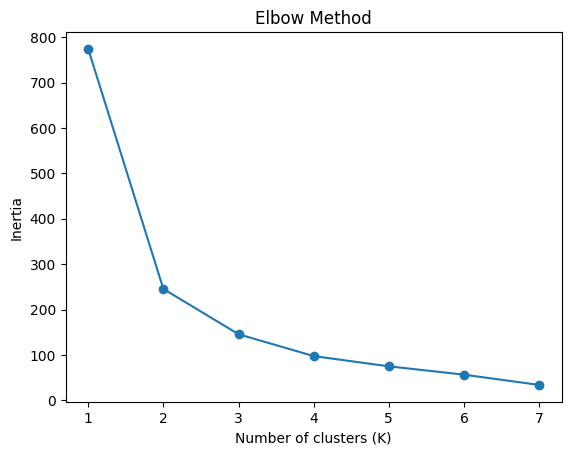

In [72]:
inertias = []
K_range = range(1, 8)

for k in K_range:
    km = Kmeans(k, X_train_scaled)
    labels, centroids = km.fit()
    inertia = 0
    for i in range(k):
        inertia += np.sum((X_train_scaled[labels == i] - centroids[i])**2)
    inertias.append(inertia)

plt.figure()
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [74]:
kmeans = Kmeans(3, X_train_scaled)
kmeans_labels = kmeans.fit()

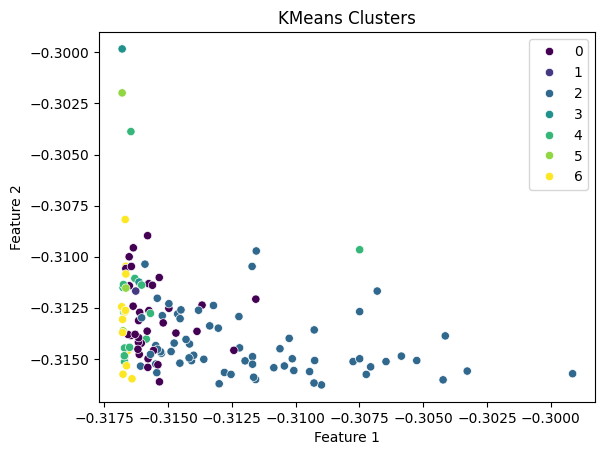

In [75]:
plt.figure()
sns.scatterplot(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    hue=labels,
    palette='viridis'
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KMeans Clusters")
plt.show()

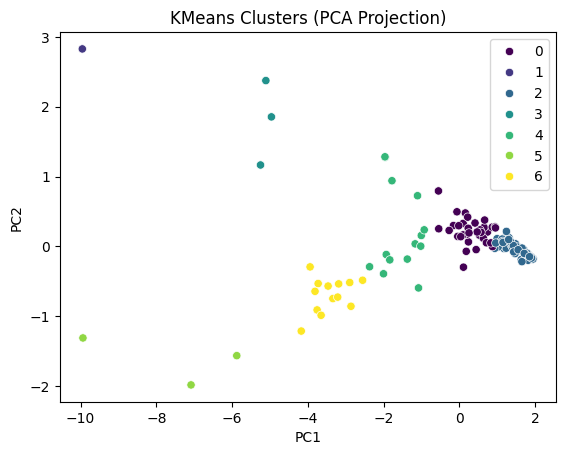

In [77]:
# center the data
X_centered = X_train_scaled - np.mean(X_train_scaled, axis=0)

cov = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eig(cov)

idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]

X_pca = X_centered @ eigvecs[:, :2]

plt.figure()
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (PCA Projection)")
plt.show()

# KNN on Kmeans label

In [78]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X_test):
        preds = []
        for x in X_test:
            distances = np.linalg.norm(self.X - x, axis=1)
            idx = np.argsort(distances)[:self.k]
            labels = self.y[idx]

            values, counts = np.unique(labels, return_counts=True)
            preds.append(values[np.argmax(counts)])

        return np.array(preds)

In [87]:
kmeans = Kmeans(3, X_train_scaled)
train_labels, centroids = kmeans.fit()

test_labels = kmeans.predict(X_test_scaled)

In [88]:
knn = KNN(5)
knn.fit(X_train_scaled, train_labels)

In [89]:
knn_pred = knn.predict(X_test_scaled)

In [90]:
accuracy = np.mean(knn_pred == test_labels)
print("Accuracy:", accuracy)

Accuracy: 1.0


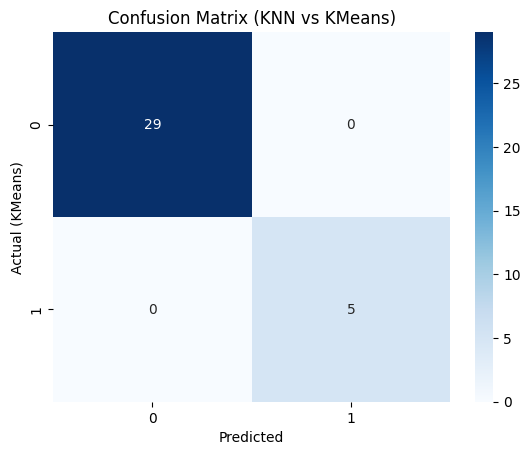

In [91]:
num_classes = len(np.unique(test_labels))
cm = np.zeros((num_classes, num_classes), dtype=int)

for t, p in zip(test_labels, knn_pred):
    cm[t, p] += 1

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual (KMeans)")
plt.title("Confusion Matrix (KNN vs KMeans)")
plt.show()

In [92]:
precision = []
recall = []
f1 = []

for c in range(num_classes):
    TP = cm[c, c]
    FP = cm[:, c].sum() - TP
    FN = cm[c, :].sum() - TP

    p = TP / (TP + FP + 1e-9)
    r = TP / (TP + FN + 1e-9)

    precision.append(p)
    recall.append(r)
    f1.append(2 * p * r / (p + r + 1e-9))

print("Precision (macro):", np.mean(precision))
print("Recall (macro):", np.mean(recall))
print("F1-score (macro):", np.mean(f1))

Precision (macro): 0.9999999998827587
Recall (macro): 0.9999999998827587
F1-score (macro): 0.9999999993827586
